# Directed Acyclic Graphs & Topological Sort

In this tutorial, we will explore the algorithms related to a directed acyclic graph
(or a "DAG" as it is sometimes called) implemented in NetworkX under [`networkx/algorithms/dag.py`](https://github.com/networkx/networkx/blob/main/networkx/algorithms/dag.py).

First of all, we need to understand what a directed graph is.

## Import packages

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import inspect

%matplotlib inline

## Example: Directed Graphs

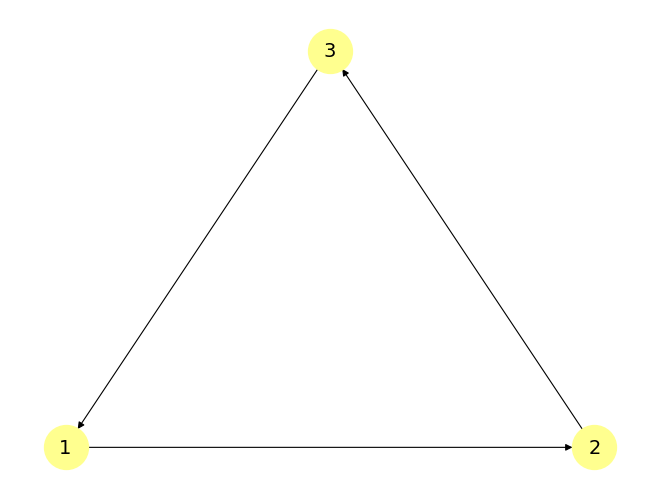

In [2]:
triangle_graph = nx.DiGraph([(1, 2), (2, 3), (3, 1)])
nx.draw_planar(
    triangle_graph,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.8,
    font_size=14,
)

### Definition

In mathematics, and more specifically in graph theory,
a directed graph (or DiGraph) is a graph that is made up of a set of vertices
connected by directed edges often called arcs.
Edges here have _directionality_, which stands in contrast to undirected graphs
where, semantically, edges have no notion of a direction to them.
Directed acyclic graphs take this idea further;
by being _acyclic_, they have no _cycles_ in them.
You will see this idea in action in the examples below.

## Directed Acyclic Graph

### Example

In [3]:
clothing_graph = nx.read_graphml(f"data/clothing_graph.graphml")

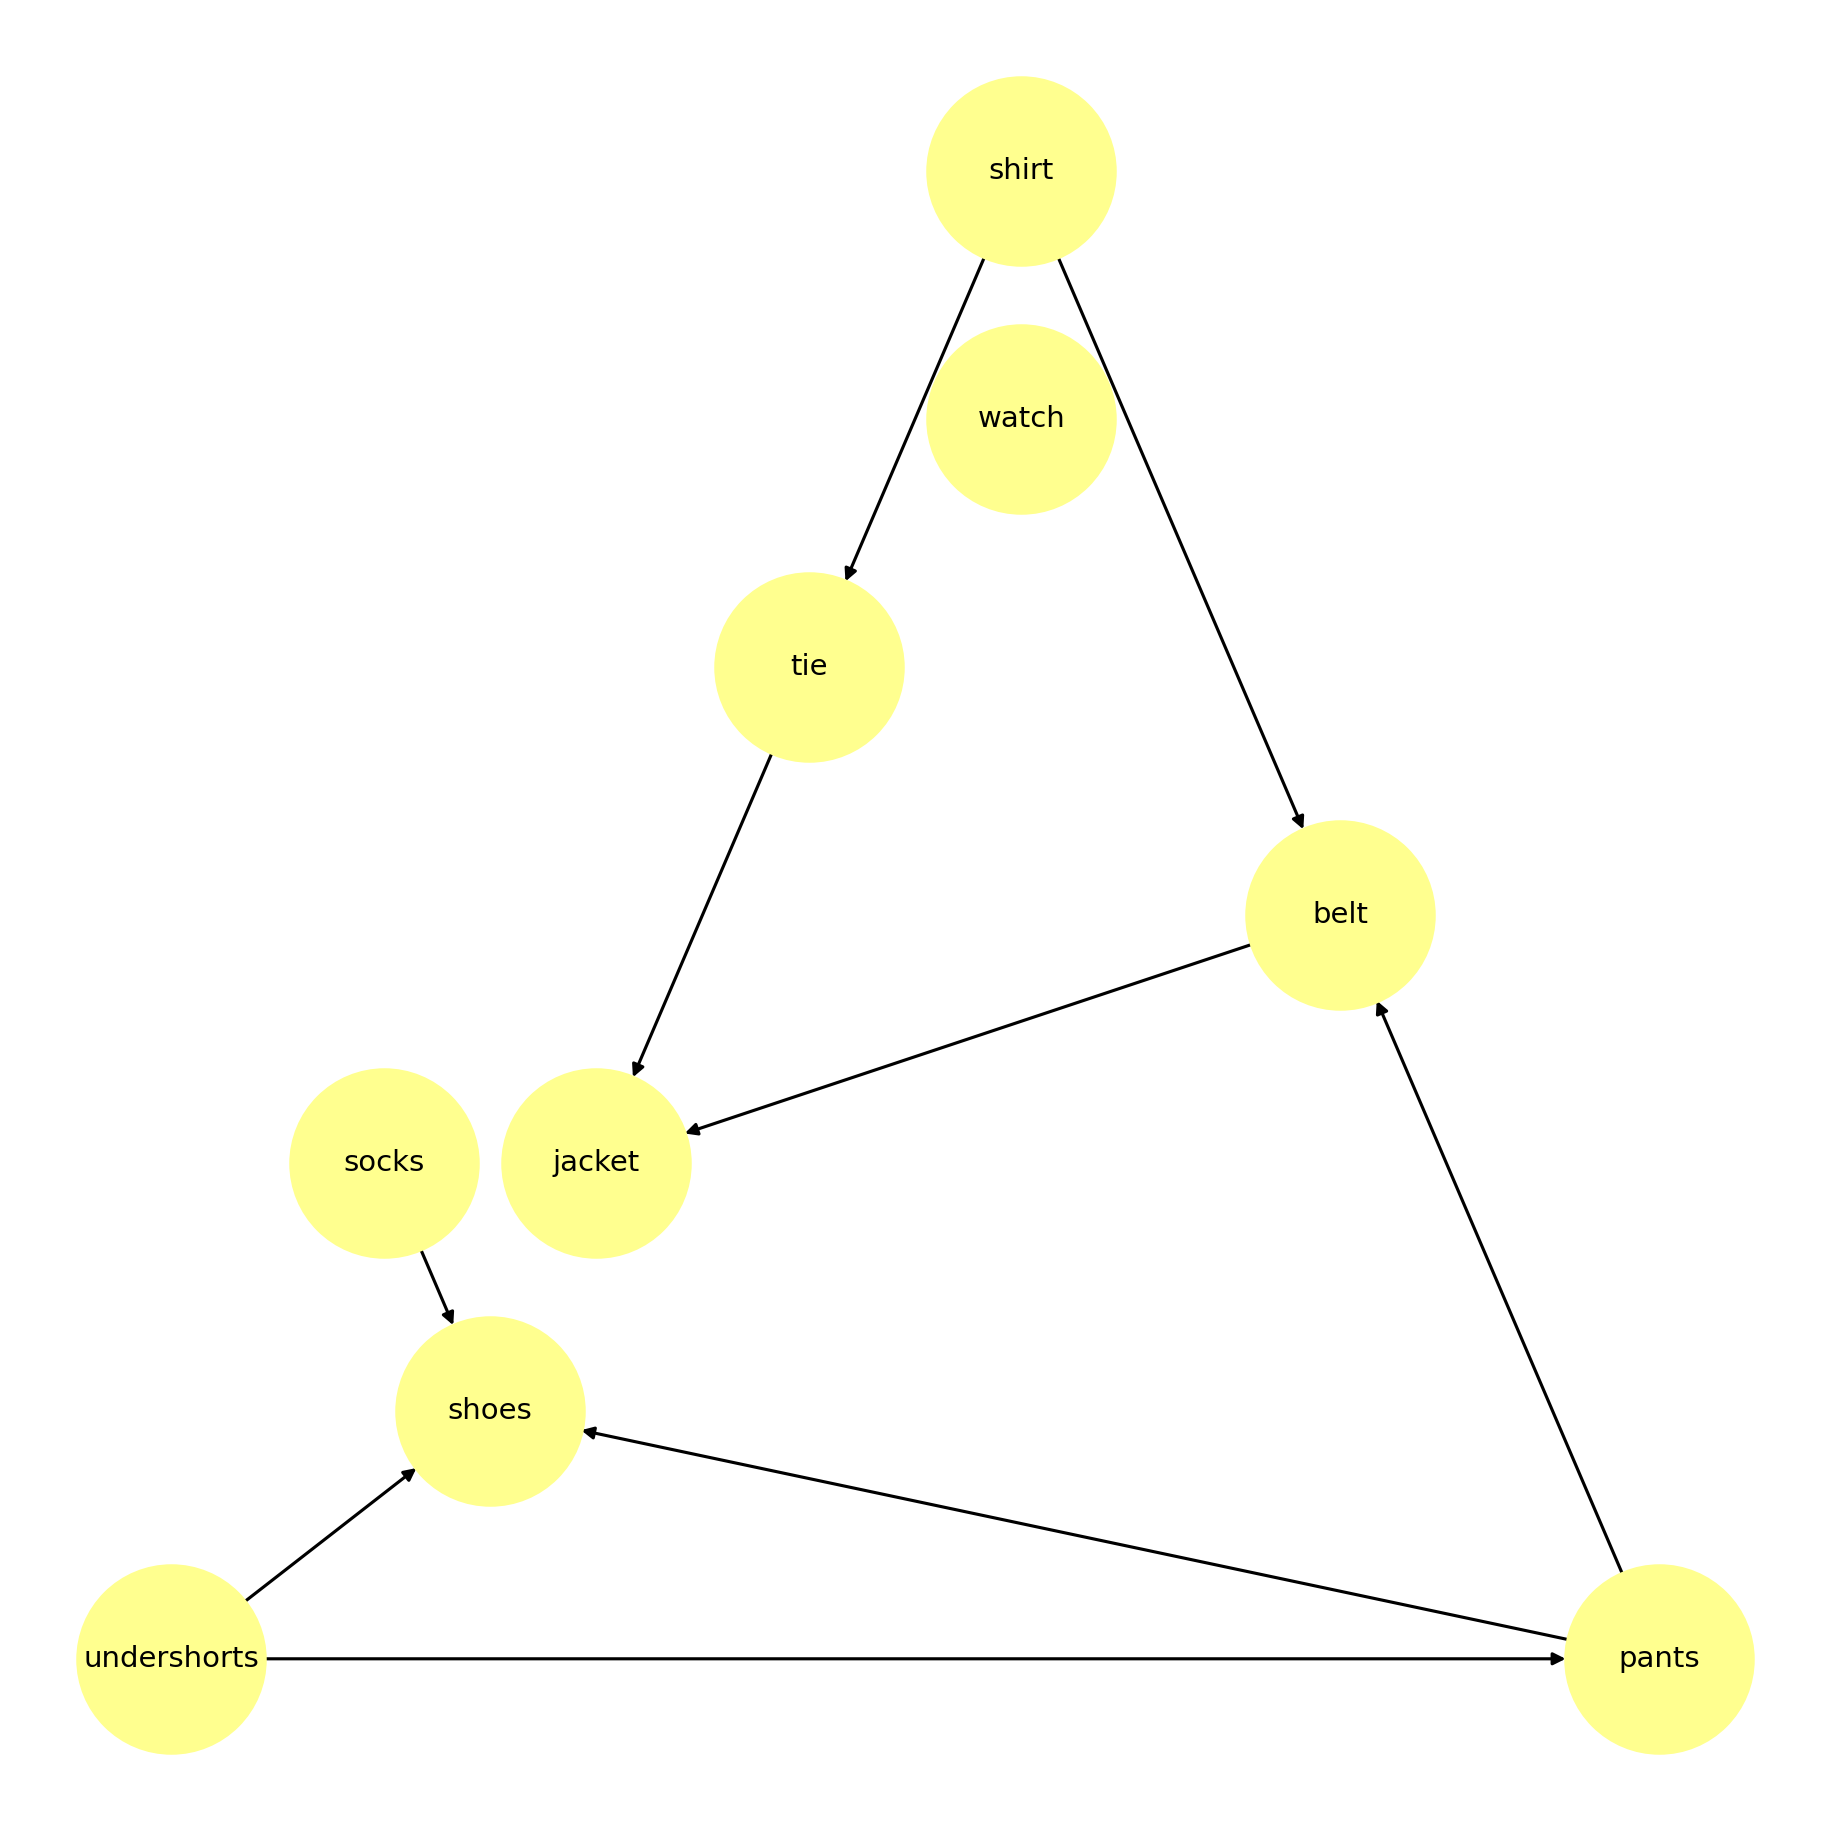

In [4]:
plt.figure(figsize=(12, 12), dpi=150)
nx.draw_planar(
    clothing_graph,
    arrowsize=12,
    with_labels=True,
    node_size=8000,
    node_color="#ffff8f",
    linewidths=2.0,
    width=1.5,
    font_size=14,
)

Here is a fun example of Professor Bumstead,
who has a routine for getting dressed in the morning.
By habit, the professor dons certain garments before others (e.g., socks before shoes).
Other items may be put on in any order (e.g., socks and pants).

A directed edge $(u, v)$ in the example indicates that garment $u$
must be donned before garment $v$.

In this example, the `clothing_graph` is a DAG.

In [5]:
nx.is_directed_acyclic_graph(clothing_graph)

True

By contrast, the `triangle_graph` is not a DAG.

In [6]:
nx.is_directed_acyclic_graph(triangle_graph)

False

This is because the `triangle_graph` has a cycle:

In [7]:
nx.find_cycle(triangle_graph)

[(1, 2), (2, 3), (3, 1)]

### Applications

Directed acyclic graphs representations of partial orderings have many applications in scheduling
of systems of tasks with ordering constraints.
An important class of problems of this type concern collections of objects that need to be updated,
for example, calculating the order of cells of a spreadsheet to update after one of the cells has been changed,
or identifying which object files of software to update after its source code has been changed.
In these contexts, we use a dependency graph, which is a graph that has a vertex for each object to be updated,
and an edge connecting two objects whenever one of them needs to be updated earlier than the other.
A cycle in this graph is called a circular dependency, and is generally not allowed,
because there would be no way to consistently schedule the tasks involved in the cycle.
Dependency graphs without circular dependencies form DAGs.

A directed acyclic graph may also be used to represent a network of processing elements.
In this representation, data enters a processing element through its incoming edges
and leaves the element through its outgoing edges.
For instance, in electronic circuit design, static combinational logic blocks
can be represented as an acyclic system of logic gates that computes a function of an input,
where the input and output of the function are represented as individual bits.

### Definition

A directed acyclic graph ("DAG" or "dag") is a directed graph with no directed cycles.
That is, it consists of vertices and edges (also called arcs), with each edge directed from one vertex to another,
such that following those directions will never form a closed loop.

A directed graph is a DAG if and only if it can be topologically ordered
by arranging the vertices as a linear ordering that is consistent with all edge directions.

## Topological sort

Let's now introduce what the topological sort is.

### Example

In [8]:
list(nx.topological_sort(clothing_graph))

['undershorts',
 'shirt',
 'socks',
 'watch',
 'pants',
 'tie',
 'belt',
 'shoes',
 'jacket']

### Applications

The canonical application of topological sorting is in scheduling a sequence of jobs
or tasks based on their dependencies.
The jobs are represented by vertices, and there is an edge from $u$ to $v$
if job $u$ must be completed before job $v$ can be started
(for example, when washing clothes, the washing machine must finish before we put the clothes in the dryer).
Then, a topological sort gives an order in which to perform the jobs.

A closely related application of topological sorting algorithms
was first studied in the early 1960s in the context of the
PERT technique [^1]
for scheduling in project management.
In this application, the vertices of a graph represent the milestones of a project,
and the edges represent tasks that must be performed between one milestone and another.
Topological sorting forms the basis of linear-time algorithms for finding
the critical path of the project, a sequence of milestones and tasks that controls
the length of the overall project schedule.

In computer science, applications of this type arise in instruction scheduling,
ordering of formula cell evaluation when recomputing formula values in spreadsheets,
logic synthesis, determining the order of compilation tasks to perform in makefiles,
data serialization, and resolving symbol dependencies in linkers.
It is also used to decide in which order to load tables with foreign keys in databases.

### Definition

A topological sort of a directed acyclic graph $G = (V, E)$ is a linear ordering of all its vertices
such that if $G$ contains an edge $(u, v)$, then $u$ appears before $v$ in the ordering.

It is worth noting that if the graph contains a cycle, then no linear ordering is possible.

It is useful to view a topological sort of a graph as an ordering of its vertices
along a horizontal line so that all directed edges go from left to right.

### Kahn's algorithm

NetworkX uses Kahn's algorithm to perform topological sorting.
We will introduce it briefly here.

First, find a list of "start nodes" which have no incoming edges and insert them into a set S;
at least one such node must exist in a non-empty acyclic graph. Then:

```
L <- Empty list that will contain the sorted elements
S <- Set of all nodes with no incoming edge

while S is not empty do
    remove a node N from S
    add N to L
    for each node M with an edge E from N to M do
        remove edge E from the graph
        if M has no other incoming edges then
            insert M into S

if graph has edges then
    return error  # graph has at least one cycle
else 
    return L  # a topologically sorted order
```

### NetworkX implementation

Finally, let's take a look at how the topological sorting is implemented in NetworkX.

We can see that Kahn's algorithm _stratifies_ the graph such that each level contains all the nodes
whose dependencies have been satisfied by the nodes in a previous level.
In other words, Kahn's algorithm does something like:
  - Take all the nodes in the DAG that don't have any dependencies and put them in list.
  - "Remove" those nodes from the DAG.
  - Repeat the process, creating a new list at each step.
Thus, topological sorting is reduced to correctly stratifying the graph in this way.

This procedure is implemented in the `topological_generations()` function, on which the `topological_sort()` function is based.

Let's see how the `topological_generations()` function is implemented in NetworkX step by step.

#### Step 1. Initialize indegrees.

Since in Kahn's algorithm we are only interested in the indegrees of the vertices,
in order to preserve the structure of the graph as it is passed in,
instead of removing the edges, we will decrease the indegree of the corresponding vertex.
Therefore, we will save these values in a separate _dictionary_ `indegree_map`.

```
indegree_map = {v: d for v, d in G.in_degree() if d > 0}
```

#### Step 2. Initialize first level.

At each step of Kahn's algorithm, we seek out vertices with an in-degree of zero.
In preparation for the first loop iteration of the algorithm,
we can initialize a list called `zero_indegree` that houses these nodes:

```
zero_indegree = [v for v, d in G.in_degree() if d == 0]
```

#### Step 3. Move from one level to the next.

Now, we will show how the algorithm moves from one level to the next.

Inside the loop, the first generation to be considered (`this_generation`)
is the collection of nodes that have zero in-degrees.

We process all the vertices of the current level in variable `this_generation`
and we store the next level in variable `zero_degree`.

For each vertex inside `this_generation`,
we remove all of its outgoing edges.

Then, if the input degree of some vertex is zeroed as a result,
then we add it to the next level `zero_indegree`
and remove it from the `indegree_map` dictionary.

After we have processed all of the nodes inside `this_generation`, we can yield it.

```
while zero_indegree:
    this_generation = zero_indegree
    zero_indegree = []
    for node in this_generation:
        for child in G.neighbors(node):
            indegree_map[child] -= 1

            if indegree_map[child] == 0:
                zero_indegree.append(child)
                del indegree_map[child]

    yield this_generation
```

#### Step 4. Check if there is a cycle in the graph.

If, after completing the loop there are still vertices in the graph,
then there is a cycle in it and the graph is not a DAG.

```
if indegree_map:
    raise nx.NetworkXUnfeasible(
        "Graph contains a cycle or graph changed during iteration"
    )
```

#### Addendum: Topological sort works on multigraphs as well.

This is possible to do by slightly modifying the algorithm above.

* Firstly, check if `G` is a multigraph
  ```
  multigraph = G.is_multigraph()
  ```

* Then, replace
  ```
  indegree_map[child] -= 1
  ```
  with
  ```
  indegree_map[child] -= len(G[node][child]) if multigraph else 1
  ```

#### Addendum: The graph may have changed during the iteration.

Between passing different levels in a topological sort, the graph could change.
We need to check this while the `while` loop is running.

* To do this, just replace
  ```
  for node in this_generation:
      for child in G.neighbors(node):
          indegree_map[child] -= 1
  ```
  with
  ```
  for node in this_generation:
      if node not in G:
          raise RuntimeError("Graph changed during iteration")
      for child in G.neighbors(node):
          try:
              indegree_map[child] -= 1
          except KeyError as e:
              raise RuntimeError("Graph changed during iteration") from e
  ```

#### Combine all steps.

Combining all of the above gives the current implementation of the `topological_generations()` function in NetworkX.

In [9]:
print(inspect.getsource(nx.topological_generations))

@nx._dispatch
def topological_generations(G):
    """Stratifies a DAG into generations.

    A topological generation is node collection in which ancestors of a node in each
    generation are guaranteed to be in a previous generation, and any descendants of
    a node are guaranteed to be in a following generation. Nodes are guaranteed to
    be in the earliest possible generation that they can belong to.

    Parameters
    ----------
    G : NetworkX digraph
        A directed acyclic graph (DAG)

    Yields
    ------
    sets of nodes
        Yields sets of nodes representing each generation.

    Raises
    ------
    NetworkXError
        Generations are defined for directed graphs only. If the graph
        `G` is undirected, a :exc:`NetworkXError` is raised.

    NetworkXUnfeasible
        If `G` is not a directed acyclic graph (DAG) no topological generations
        exist and a :exc:`NetworkXUnfeasible` exception is raised.  This can also
        be raised if `G` is changed 

Let's finally see what the result will be on the `clothing_graph`.

In [10]:
list(nx.topological_generations(clothing_graph))

[['undershorts', 'shirt', 'socks', 'watch'],
 ['pants', 'tie'],
 ['belt', 'shoes'],
 ['jacket']]

## References

[^1]: [Wikipedia, PERT Technique](https://en.wikipedia.org/wiki/Program_evaluation_and_review_technique)